# Explorative Datenanalyse

In [7]:
%pip install numpy
%pip install pandas
%pip install pyarrow
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Import Data

In [10]:
products_source = pd.read_csv('data/products.csv')
stores_source   = pd.read_csv('data/stores.csv')

In [11]:
transaction_lines_test_source   = pd.read_parquet('data/transaction_lines_test_1.parquet')
transaction_lines_train_source  = pd.read_parquet('data/transaction_lines_train_1.parquet')
transactions_test_source        = pd.read_parquet('data/transactions_test_1.parquet')
transactions_train_source       = pd.read_parquet('data/transactions_train_1.parquet')

# Joint Set erstellen

In [12]:
# Merge transactions with stores. Keep all transactions (left join).
# Suffix '_store' is added to columns from stores_source if they conflict
transactions_enriched = pd.merge(
    transactions_train_source,
    stores_source,
    left_on='store_id',
    right_on='id', # 'id' column from stores_source
    how='left',
    suffixes=('', '_store') # Add suffix to store columns if needed
)
# Drop the redundant 'id' column from the stores table after merge
transactions_enriched = transactions_enriched.drop(columns=['id_store'], errors='ignore') # Use errors='ignore' in case suffix wasn't needed
print("Transactions enriched with store info:")
print(transactions_enriched.info())

Transactions enriched with store info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558245 entries, 0 to 1558244
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1558245 non-null  object        
 1   store_id           1558245 non-null  object        
 2   cash_desk          1558245 non-null  int64         
 3   transaction_start  1558245 non-null  datetime64[us]
 4   transaction_end    1558245 non-null  datetime64[us]
 5   total_amount       1558245 non-null  float64       
 6   n_lines            1558245 non-null  int64         
 7   payment_medium     1558245 non-null  object        
 8   customer_feedback  108330 non-null   float64       
 9   damage             155692 non-null   float64       
 10  label              1558245 non-null  object        
 11  opening_date       1558245 non-null  object        
 12  location           1558245 non-null  object  

In [13]:
# Merge transaction lines with products. Keep all lines (left join).
# Suffix '_product' is added to columns from products_source if they conflict
lines_enriched = pd.merge(
    transaction_lines_train_source,
    products_source,
    left_on='product_id',
    right_on='id', # 'id' column from products_source
    how='left',
    suffixes=('', '_product') # Add suffix to product columns if needed
)
# Drop the redundant 'id' column from the products table after merge
lines_enriched = lines_enriched.drop(columns=['id_product'], errors='ignore') # Use errors='ignore'
print("Transaction lines enriched with product info:")
print(lines_enriched.info())

Transaction lines enriched with product info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16620157 entries, 0 to 16620156
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      int64         
 1   transaction_id          object        
 2   product_id              object        
 3   timestamp               datetime64[us]
 4   pieces_or_weight        float64       
 5   sales_price             float64       
 6   was_voided              bool          
 7   camera_product_similar  object        
 8   camera_certainty        float64       
 9   base_product_id         object        
 10  category                object        
 11  price                   float64       
 12  popularity              float64       
 13  valid_from              object        
 14  valid_to                object        
 15  sold_by_weight          object        
 16  weight                  float64       
 17

# Tasactions enriched bereinigung

So, wir wollen uns ein training dataframe bauen. Dafür müssen wir nach und nach alle columns durchgehen und anschauen was die beste wahl hier wäre. Wir analysieren den ganzen datensatz um allen daten gerächt zu werden, aber natürlich wollen wir unser trainings set nur auf den gelabelten Daten durchführen.

In [14]:
transactions_cleaned = transactions_enriched.copy()

In [15]:
transactions_cleaned = transactions_cleaned[transactions_cleaned['label'] != 'UNKNOWN']

## Spalte "cash_desk"

#### Anzahl der verschiedenen Elemente

In [16]:
# Anzahl der eindeutigen Werte in 'cash_desk'
unique_cash_desks = transactions_enriched['cash_desk'].nunique()
print(f"Anzahl der eindeutigen Kassennummern: {unique_cash_desks}")

Anzahl der eindeutigen Kassennummern: 4


In [17]:
# Häufigkeit jeder Kassennummer anzeigen (hilft bei der Identifizierung von Duplikaten/Verteilung)
cash_desk_counts = transactions_enriched['cash_desk'].value_counts().sort_index()
print("\nHäufigkeit der einzelnen Kassennummern:")
cash_desk_counts


Häufigkeit der einzelnen Kassennummern:


cash_desk
0    390166
1    389773
2    389160
3    389146
Name: count, dtype: int64

Wir haben keine null values und nur vier Gruppen. Also werden wir cash_desk als Kategorische Spalte absondern.

### Säuberung

In [18]:
# Initialisiere den Encoder
sparse_output=False # gibt eine dichte NumPy-Array zurück, was oft einfacher zu handhaben ist
handle_unknown='ignore' # kann nützlich sein, wenn in Testdaten neue Kategorien auftauchen könnten
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Die Spalte muss für den Encoder in ein 2D-Array umgeformt werden
cash_desk_column = transactions_cleaned[['cash_desk']]

# Encoder anpassen und transformieren
encoded_data = encoder.fit_transform(cash_desk_column)

# Die Namen der neuen Spalten abrufen
encoded_feature_names = encoder.get_feature_names_out(['cash_desk'])

# Das Ergebnis in einen DataFrame umwandeln
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=transactions_cleaned.index, dtype=int)

# Die encodierten Spalten mit dem Rest des DataFrames zusammenführen
transactions_cleaned_sklearn = pd.concat([transactions_cleaned.drop(columns=['cash_desk']), encoded_df], axis=1)

transactions_cleaned = transactions_cleaned_sklearn

In [19]:
transactions_cleaned

,id,store_id,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label,opening_date,location,state,urbanization,sco_introduction,cash_desk_0,cash_desk_1,cash_desk_2,cash_desk_3
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,2022-02-02 08:07:12.000000,2022-02-02 08:11:29.434607,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,0,1,0
5,fc8400da-2ac2-4984-bb8f-a6ea29df955a,b0973ffa-ce15-41e0-9de7-1390598e24f2,2022-02-02 08:21:12.000000,2022-02-02 08:21:48.404849,75.58,3,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0
9,3d7dbe6e-2a67-4a4d-8011-394b44774c53,b0973ffa-ce15-41e0-9de7-1390598e24f2,2022-02-02 08:48:09.000000,2022-02-02 08:51:20.530141,218.51,23,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0
17,d54e5513-bdbe-4129-bafc-dc4a15747260,b0973ffa-ce15-41e0-9de7-1390598e24f2,2022-02-02 09:11:15.000000,2022-02-02 09:14:02.177041,323.95,27,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0
32,6e1a71c4-b210-427e-8882-5385f9b9253e,b0973ffa-ce15-41e0-9de7-1390598e24f2,2022-02-02 10:04:06.000000,2022-02-02 10:04:27.311571,58.87,4,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558167,93e0f4b3-810a-46c7-837e-7b84b2a4c673,ed996b17-17d6-47e8-9262-d1d02b52cdb4,2023-12-30 21:12:15.000000,2023-12-30 21:13:17.665744,47.28,8,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,1,0,0,0
1558170,81d32eb7-7b5d-48e5-9c25-18a0148ba907,ed996b17-17d6-47e8-9262-d1d02b52cdb4,2023-12-30 21:13:18.000000,2023-12-30 21:16:37.092689,264.25,22,CREDIT_CARD,10.0,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,0,1,0
1558173,14ce6f9e-64a9-4c93-b834-cde34d80704d,ed996b17-17d6-47e8-9262-d1d02b52cdb4,2023-12-30 21:14:42.000000,2023-12-30 21:19:28.465321,297.95,38,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,1,0,0
1558175,c63b715f-4b23-485a-92e9-7bca82775d4c,ed996b17-17d6-47e8-9262-d1d02b52cdb4,2023-12-30 21:16:41.074339,2023-12-30 21:19:32.503266,398.57,27,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,0,1,0


## Spalte "transaction_start" und "transaction_end"

In [20]:
min_date = transactions_enriched['transaction_start'].min()
max_date = transactions_enriched['transaction_start'].max()
print(f"\nFrühester Transaktionsstart: {min_date}")
print(f"Spätester Transaktionsstart: {max_date}")
print(f"Abgedeckter Zeitraum: {max_date - min_date}")

print(f"\nAnzahl eindeutiger Zeitstempel: {transactions_enriched['transaction_start'].nunique()}")
print(f"Gesamtzahl der Zeilen: {len(transactions_enriched)}")

if transactions_enriched['transaction_start'].nunique() < len(transactions_enriched):
    print("Es gibt doppelte Zeitstempel in 'transaction_start'.")
    duplicate_timestamps_count = transactions_enriched.duplicated(subset=['transaction_start']).sum()
    print(f"Anzahl der Zeilen mit doppeltem Zeitstempel (basierend auf erster Erscheinung): {duplicate_timestamps_count}")
    # Um die tatsächlichen Duplikate zu sehen:
    # print("\nBeispiele für doppelte Zeitstempel (alle Vorkommen):")
    # print(transactions_enriched[transactions_enriched['transaction_start'].duplicated(keep=False)].sort_values('transaction_start').head())
else:
    print("Alle Zeitstempel in 'transaction_start' sind eindeutig.")


Frühester Transaktionsstart: 2022-02-02 08:00:12
Spätester Transaktionsstart: 2023-12-30 21:59:30
Abgedeckter Zeitraum: 696 days 13:59:18

Anzahl eindeutiger Zeitstempel: 1106707
Gesamtzahl der Zeilen: 1558245
Es gibt doppelte Zeitstempel in 'transaction_start'.
Anzahl der Zeilen mit doppeltem Zeitstempel (basierend auf erster Erscheinung): 451538


In [21]:
min_date_end = transactions_enriched['transaction_end'].min()
max_date_end = transactions_enriched['transaction_end'].max()
print(f"\nFrühester Transaktionsende: {min_date_end}")
print(f"Spätester Transaktionsende: {max_date_end}")
if 'transaction_start' in transactions_enriched.columns and transactions_enriched['transaction_start'].dtype == 'datetime64[us]':
    overall_min_date = min(transactions_enriched['transaction_start'].min(), min_date_end)
    overall_max_date = max(transactions_enriched['transaction_start'].max(), max_date_end)
    print(f"Gesamter abgedeckter Zeitraum (Start bis Ende): {overall_max_date - overall_min_date}")
else:
    print(f"Abgedeckter Zeitraum (nur Endzeiten): {max_date_end - min_date_end}")


print(f"\nAnzahl eindeutiger Zeitstempel in 'transaction_end': {transactions_enriched['transaction_end'].nunique()}")
print(f"Gesamtzahl der Zeilen: {len(transactions_enriched)}")

if transactions_enriched['transaction_end'].nunique() < len(transactions_enriched):
    print("Es gibt doppelte Zeitstempel in 'transaction_end'.")
    duplicate_timestamps_end_count = transactions_enriched.duplicated(subset=['transaction_end']).sum()
    print(f"Anzahl der Zeilen mit doppeltem 'transaction_end'-Zeitstempel (basierend auf erster Erscheinung): {duplicate_timestamps_end_count}")
    # Um die tatsächlichen Duplikate zu sehen (optional):
    # print("\nBeispiele für doppelte 'transaction_end'-Zeitstempel (alle Vorkommen):")
    # print(transactions_enriched[transactions_enriched['transaction_end'].duplicated(keep=False)].sort_values('transaction_end').head())
else:
    print("Alle Zeitstempel in 'transaction_end' sind eindeutig.")


Frühester Transaktionsende: 2022-02-02 08:01:02.825563
Spätester Transaktionsende: 2023-12-30 22:01:13.269469
Gesamter abgedeckter Zeitraum (Start bis Ende): 696 days 14:01:01.269469

Anzahl eindeutiger Zeitstempel in 'transaction_end': 1558245
Gesamtzahl der Zeilen: 1558245
Alle Zeitstempel in 'transaction_end' sind eindeutig.


#### Visualisierung zur Erkennung von Mustern und Anomalien

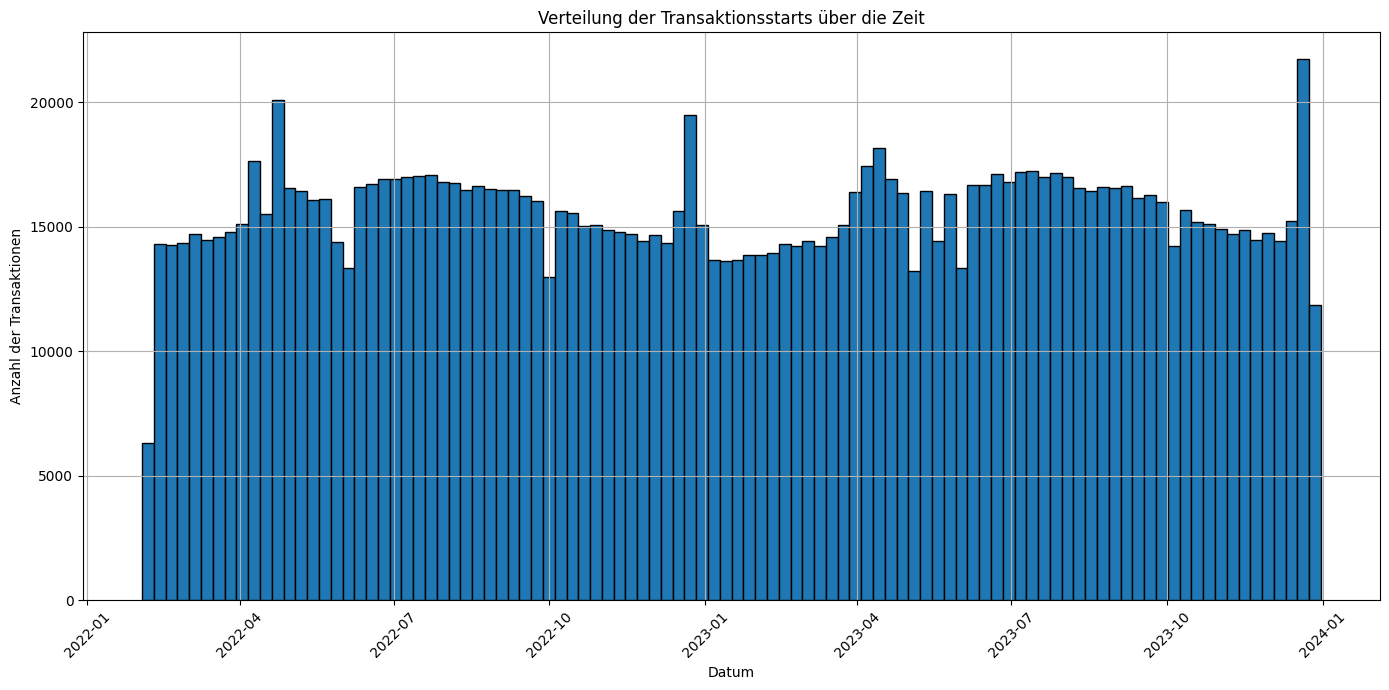

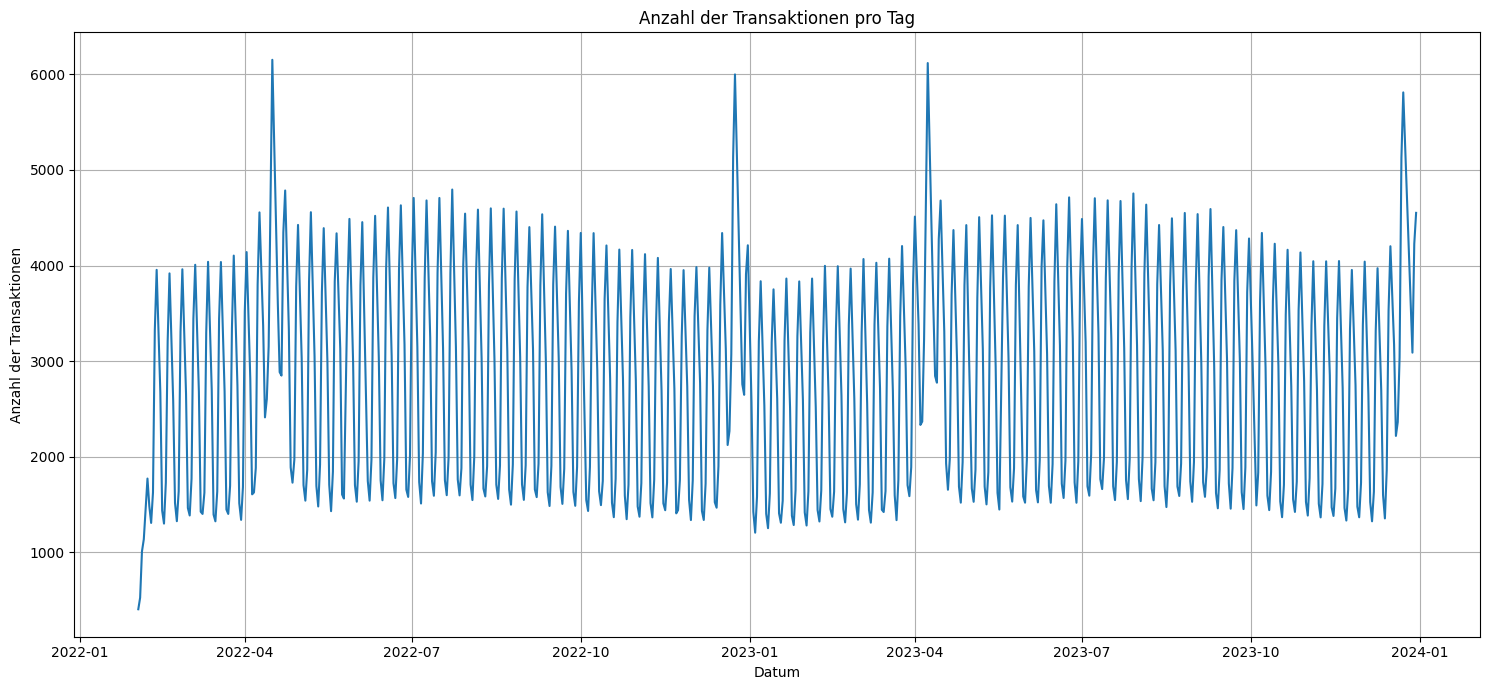

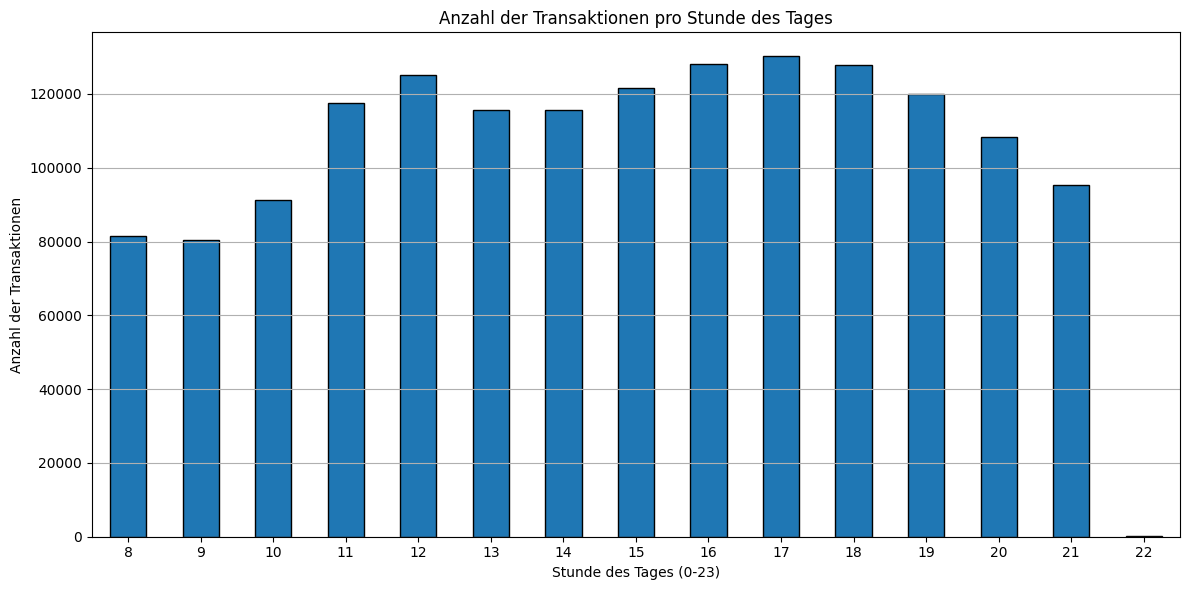

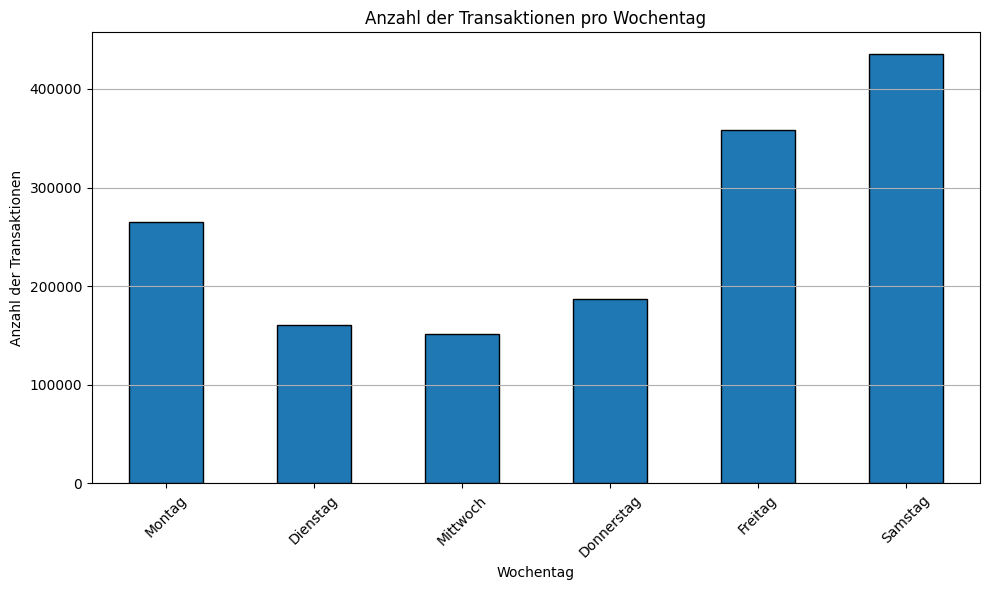

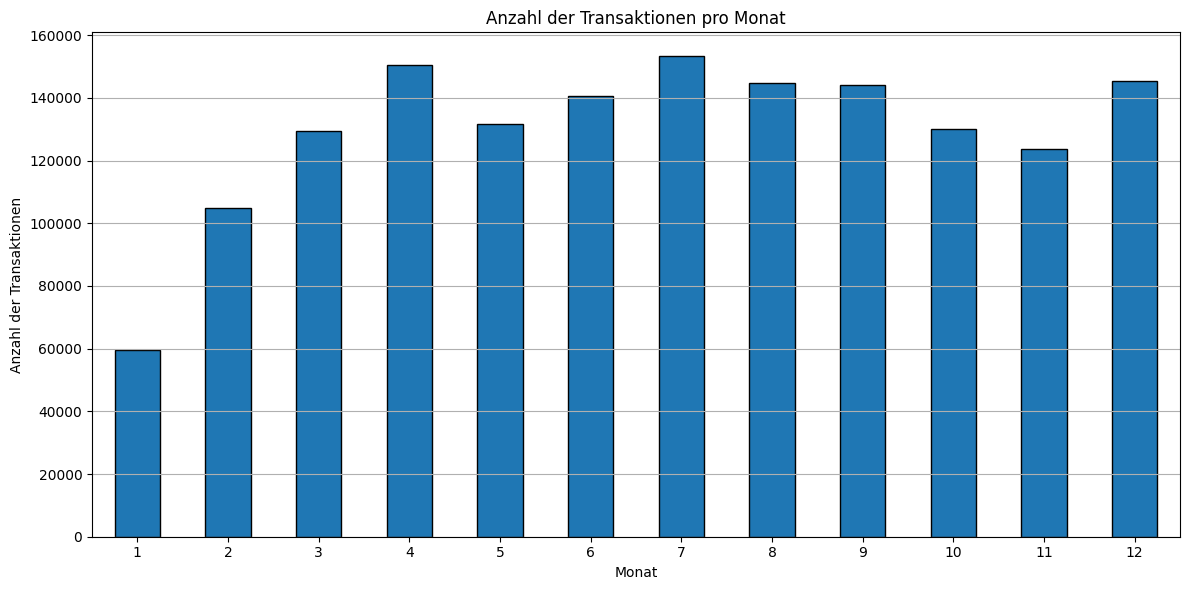

In [22]:
# Histogramm der Transaktionsstarts
plt.figure(figsize=(14, 7))
transactions_enriched['transaction_start'].hist(bins=100, edgecolor='black')
plt.title('Verteilung der Transaktionsstarts über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Erstellen temporärer Features für Visualisierungen
temp_df = transactions_enriched.copy()
temp_df['transaction_date'] = temp_df['transaction_start'].dt.date
temp_df['transaction_hour'] = temp_df['transaction_start'].dt.hour
temp_df['transaction_dayofweek'] = temp_df['transaction_start'].dt.dayofweek # Montag=0, Sonntag=6
temp_df['transaction_month'] = temp_df['transaction_start'].dt.month

# Anzahl Transaktionen pro Tag (Zeitreihenplot)
plt.figure(figsize=(15, 7))
daily_transactions = temp_df.groupby('transaction_date').size()
daily_transactions.plot()
plt.title('Anzahl der Transaktionen pro Tag')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Transaktionen')
plt.grid(True)
plt.tight_layout()
plt.show()

# Anzahl Transaktionen pro Stunde
plt.figure(figsize=(12, 6))
hourly_transactions = temp_df.groupby('transaction_hour').size()
hourly_transactions.plot(kind='bar', edgecolor='black')
plt.title('Anzahl der Transaktionen pro Stunde des Tages')
plt.xlabel('Stunde des Tages (0-23)')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Anzahl Transaktionen pro Wochentag
plt.figure(figsize=(10, 6))
dayofweek_transactions = temp_df.groupby('transaction_dayofweek').size()
dayofweek_transactions.index = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag'] # Für bessere Lesbarkeit
dayofweek_transactions.plot(kind='bar', edgecolor='black')
plt.title('Anzahl der Transaktionen pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Anzahl Transaktionen pro Monat
plt.figure(figsize=(12, 6))
monthly_transactions = temp_df.groupby('transaction_month').size()
monthly_transactions.plot(kind='bar', edgecolor='black')
plt.title('Anzahl der Transaktionen pro Monat')
plt.xlabel('Monat')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

del temp_df # Temporären DataFrame wieder löschen

In [23]:
unusual_hours_df = transactions_enriched[
    (transactions_enriched['transaction_start'].dt.hour < 8) |
    (transactions_enriched['transaction_start'].dt.hour > 21)
]
if not unusual_hours_df.empty:
    print(f"\nINFO: {len(unusual_hours_df)} Transaktionen außerhalb des angenommenen Zeitfensters 07:00-22:59 Uhr.")
    print("Beispiele für Transaktionen zu ungewöhnlichen Stunden:")
    print(unusual_hours_df[['id', 'store_id', 'transaction_start']].head())


INFO: 67 Transaktionen außerhalb des angenommenen Zeitfensters 07:00-22:59 Uhr.
Beispiele für Transaktionen zu ungewöhnlichen Stunden:
                                          id  \
34628   b89fe8cd-7e0f-4bbd-bd9c-2100f6b3028d   
137041  d498468d-378b-43e9-a6e2-37aa09e488dc   
137042  e9c44e10-a5c2-4210-853f-adb72cfacd07   
137043  5affd978-8258-47f0-a92f-5944ecf52e98   
148003  d676efa4-3166-4418-9241-274241b1818c   

                                    store_id          transaction_start  
34628   d3892a9e-8cbc-4237-be9c-211435dc92c0 2022-02-19 22:00:50.240402  
137041  b0973ffa-ce15-41e0-9de7-1390598e24f2 2022-04-16 22:00:05.703826  
137042  b0973ffa-ce15-41e0-9de7-1390598e24f2 2022-04-16 22:00:25.910922  
137043  b0973ffa-ce15-41e0-9de7-1390598e24f2 2022-04-16 22:01:52.064479  
148003  d3892a9e-8cbc-4237-be9c-211435dc92c0 2022-04-16 22:00:36.572411  


In [24]:
unusual_hours_df = transactions_enriched[
    (transactions_enriched['transaction_start'].dt.hour < 8) |
    (transactions_enriched['transaction_start'].dt.hour > 23)
]
if not unusual_hours_df.empty:
    print(f"\nINFO: {len(unusual_hours_df)} Transaktionen außerhalb des angenommenen Zeitfensters 07:00-22:59 Uhr.")
    print("Beispiele für Transaktionen zu ungewöhnlichen Stunden:")
    print(unusual_hours_df[['id', 'store_id', 'transaction_start']].head())

Von 23 bis acht uhr gibt es keine Ausreißer mehr. Ich denke das ist eine gute Zeitspanne.

Es gibt also einige wenige Transaktionen, die einige Minuten nach dem vermutlichen Ladenschluss von 22 Uhr stattgefunden haben. Das sind vermutlich tage wo man für jemanden eine Außnahme macht oder die Schlangen besonders lang waren.

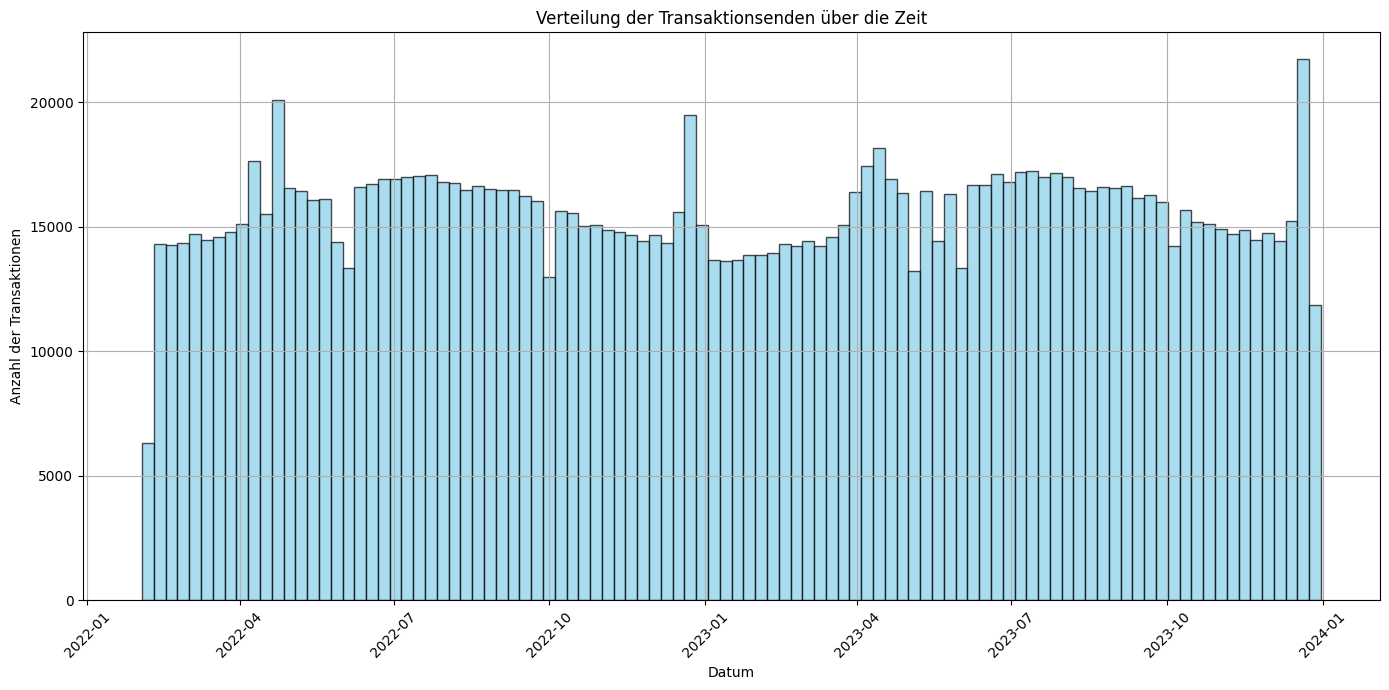

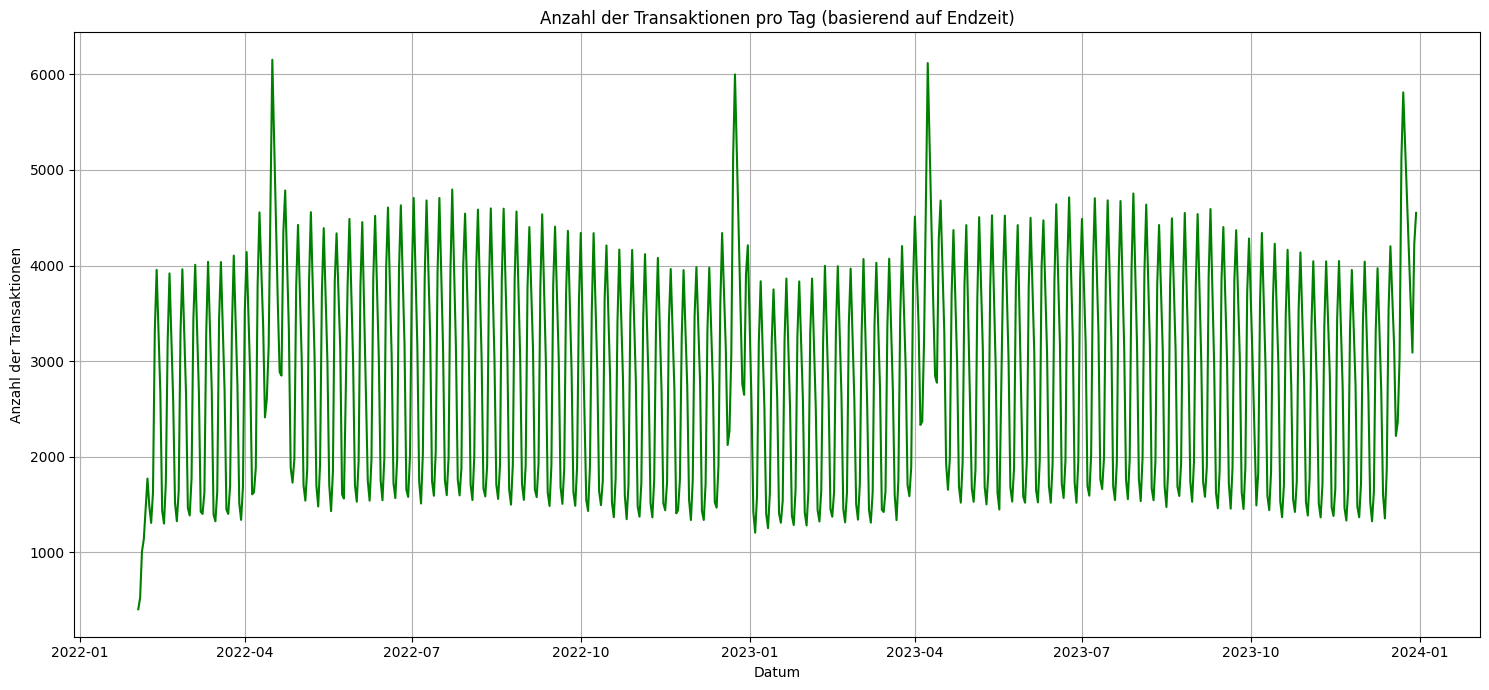

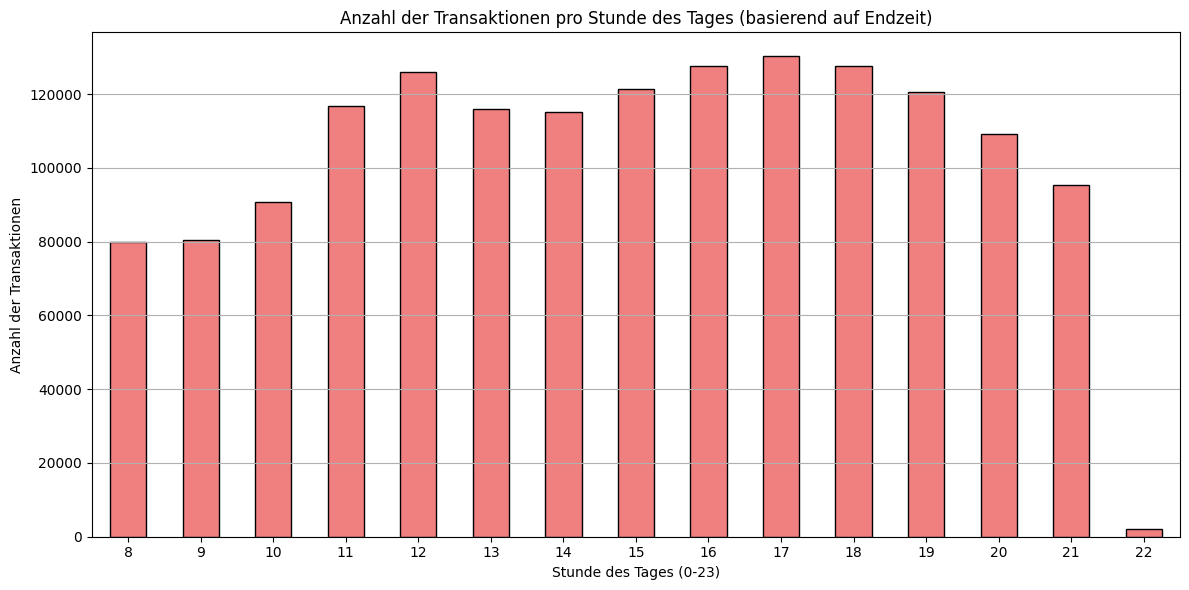

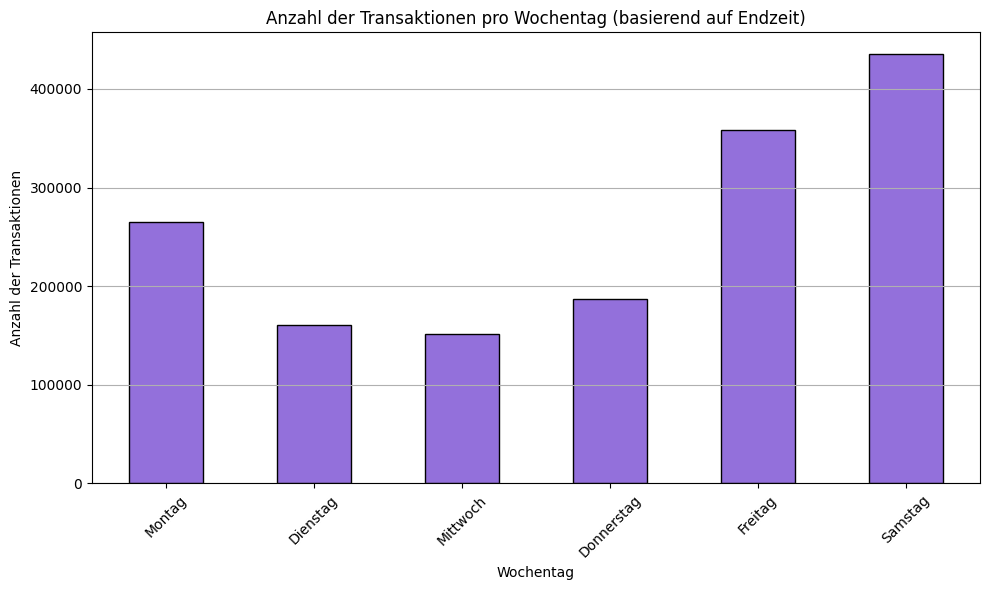

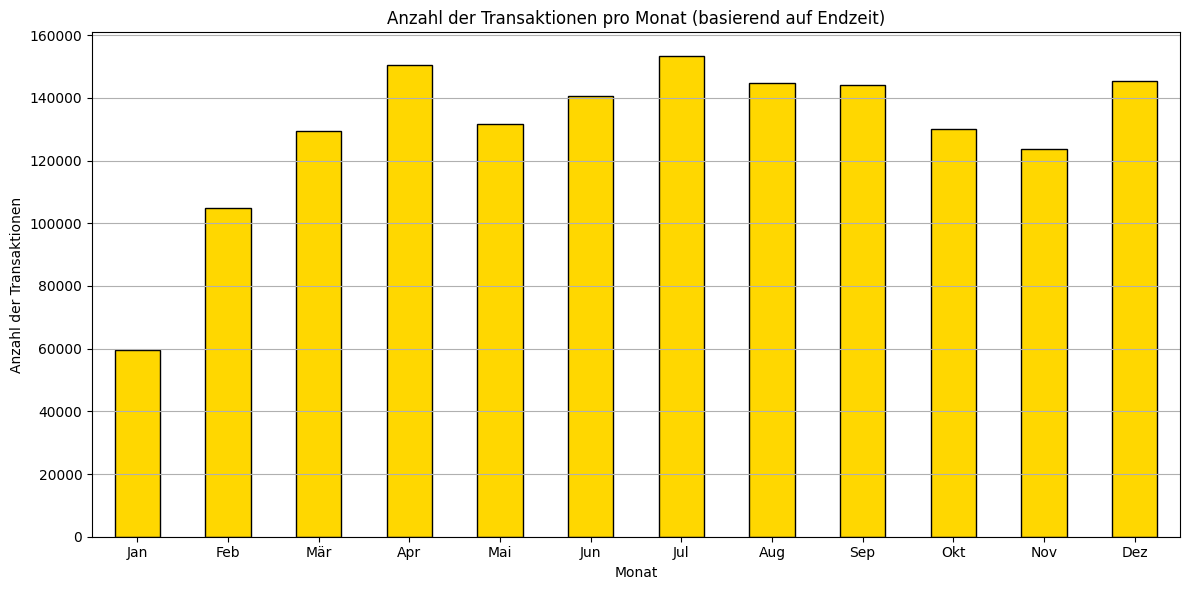

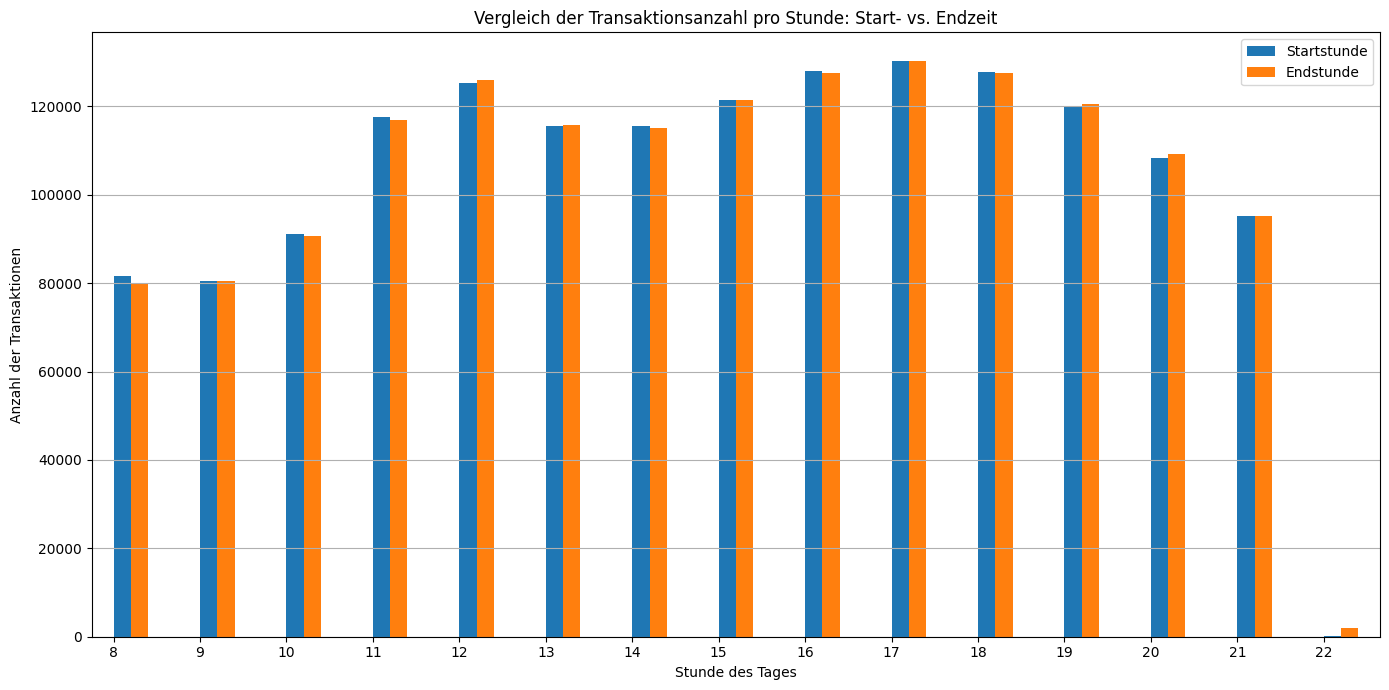

In [25]:
# Histogramm der Transaktionsenden
plt.figure(figsize=(14, 7))
transactions_enriched['transaction_end'].hist(bins=100, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Verteilung der Transaktionsenden über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Erstellen temporärer Features für Visualisierungen, spezifisch für 'transaction_end'
temp_df_end = pd.DataFrame() # Leeren DataFrame erstellen, um Fehler zu vermeiden, falls Spalte fehlt
temp_df_end['transaction_end_date'] = transactions_enriched['transaction_end'].dt.date
temp_df_end['transaction_end_hour'] = transactions_enriched['transaction_end'].dt.hour
temp_df_end['transaction_end_dayofweek'] = transactions_enriched['transaction_end'].dt.dayofweek # Montag=0, Sonntag=6
temp_df_end['transaction_end_month'] = transactions_enriched['transaction_end'].dt.month

# Anzahl Transaktionen (basierend auf Endzeit) pro Tag (Zeitreihenplot)
plt.figure(figsize=(15, 7))
daily_transactions_end = temp_df_end.groupby('transaction_end_date').size()
daily_transactions_end.plot(color='green')
plt.title('Anzahl der Transaktionen pro Tag (basierend auf Endzeit)')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Transaktionen')
plt.grid(True)
plt.tight_layout()
plt.show()

# Anzahl Transaktionen (basierend auf Endzeit) pro Stunde
plt.figure(figsize=(12, 6))
hourly_transactions_end = temp_df_end.groupby('transaction_end_hour').size()
hourly_transactions_end.plot(kind='bar', edgecolor='black', color='lightcoral')
plt.title('Anzahl der Transaktionen pro Stunde des Tages (basierend auf Endzeit)')
plt.xlabel('Stunde des Tages (0-23)')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Anzahl Transaktionen (basierend auf Endzeit) pro Wochentag
plt.figure(figsize=(10, 6))
dayofweek_transactions_end = temp_df_end.groupby('transaction_end_dayofweek').size()
# Namen für bessere Lesbarkeit
day_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
if len(dayofweek_transactions_end.index) <= len(day_names): # Sicherstellen, dass der Index nicht außerhalb der Grenzen liegt
    dayofweek_transactions_end.index = [day_names[i] for i in dayofweek_transactions_end.index]
dayofweek_transactions_end.plot(kind='bar', edgecolor='black', color='mediumpurple')
plt.title('Anzahl der Transaktionen pro Wochentag (basierend auf Endzeit)')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Anzahl Transaktionen (basierend auf Endzeit) pro Monat
plt.figure(figsize=(12, 6))
monthly_transactions_end = temp_df_end.groupby('transaction_end_month').size()
month_names = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
if len(monthly_transactions_end.index) <= len(month_names): # Sicherstellen, dass der Index nicht außerhalb der Grenzen liegt
        monthly_transactions_end.index = [month_names[i-1] for i in monthly_transactions_end.index] # Monate sind 1-basiert
monthly_transactions_end.plot(kind='bar', edgecolor='black', color='gold')
plt.title('Anzahl der Transaktionen pro Monat (basierend auf Endzeit)')
plt.xlabel('Monat')
plt.ylabel('Anzahl der Transaktionen')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# (Optional) Vergleichende Visualisierung: Start- vs. Endzeiten (z.B. stündlich)
# Dies erfordert, dass 'transaction_start' auch bereits analysiert und die entsprechenden temporären Spalten erstellt wurden.
if 'transaction_start' in transactions_enriched.columns and transactions_enriched['transaction_start'].dtype == 'datetime64[us]':
    temp_df_start_hour = transactions_enriched['transaction_start'].dt.hour.value_counts().sort_index()
    temp_df_end_hour = transactions_enriched['transaction_end'].dt.hour.value_counts().sort_index()

    comparison_df = pd.DataFrame({
        'Startstunde': temp_df_start_hour,
        'Endstunde': temp_df_end_hour
    }).fillna(0) # Fülle NaNs mit 0, falls eine Stunde in einer Spalte nicht vorkommt

    comparison_df.plot(kind='bar', figsize=(14,7), position=0, width=0.4)
    plt.title('Vergleich der Transaktionsanzahl pro Stunde: Start- vs. Endzeit')
    plt.xlabel('Stunde des Tages')
    plt.ylabel('Anzahl der Transaktionen')
    plt.xticks(rotation=0)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("\n'transaction_start' nicht für Vergleichsvisualisierung verfügbar oder hat falschen Typ.")

del temp_df_end # Temporären DataFrame wieder löschen

#### Konsistenz mit transaction_end


Konsistenzprüfung: 'transaction_start' ist immer vor 'transaction_end'.

Statistik der Transaktionsdauer:
count                   1558245
mean     0 days 00:01:17.642520
std      0 days 00:01:12.931251
min      0 days 00:00:03.453157
25%      0 days 00:00:28.201343
50%      0 days 00:00:53.189676
75%      0 days 00:01:41.728423
max      0 days 00:21:07.826431
Name: transaction_duration, dtype: object


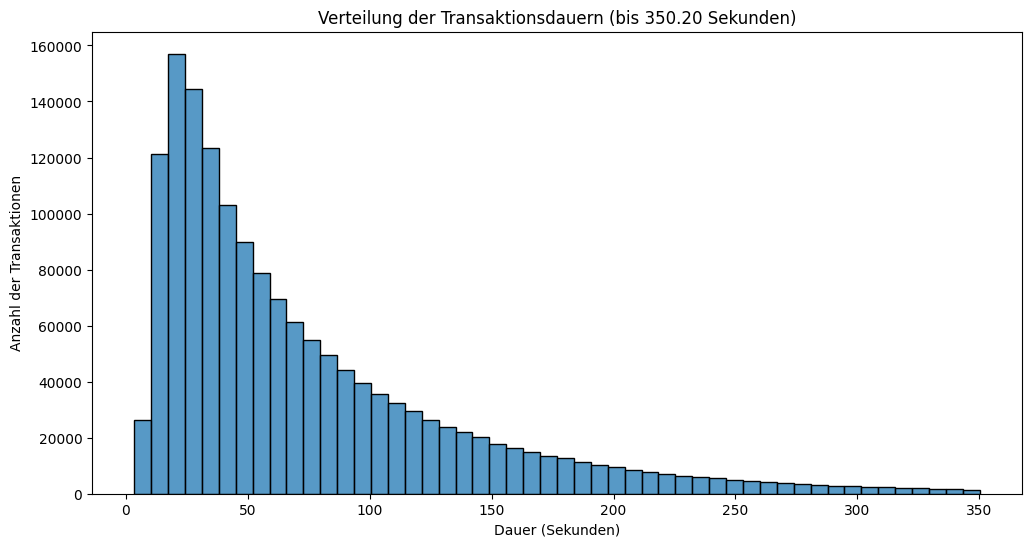

In [26]:
inconsistent_times = transactions_enriched[transactions_enriched['transaction_start'] >= transactions_enriched['transaction_end']]
if not inconsistent_times.empty:
    print(f"\nWARNUNG: {len(inconsistent_times)} Transaktionen, bei denen 'transaction_start' >= 'transaction_end' ist.")
    print("Beispiele für inkonsistente Zeitstempel:")
    print(inconsistent_times[['id', 'transaction_start', 'transaction_end']].head())
    # Überlege, wie diese Fälle behandelt werden sollen:
    # 1. Entfernen: transactions_enriched = transactions_enriched[transactions_enriched['transaction_start'] < transactions_enriched['transaction_end']].copy()
    # 2. Untersuchen und ggf. korrigieren.
    # 3. Wenn 'transaction_end' fehlerhaft ist, könnte man versuchen, es basierend auf 'transaction_start' und einer typischen Dauer zu imputieren.
else:
    print("\nKonsistenzprüfung: 'transaction_start' ist immer vor 'transaction_end'.")

# Berechnung der Transaktionsdauer (kann auch für Anomalieerkennung nützlich sein)
transactions_enriched['transaction_duration'] = (transactions_enriched['transaction_end'] - transactions_enriched['transaction_start'])
print("\nStatistik der Transaktionsdauer:")
print(transactions_enriched['transaction_duration'].describe())

# Dauer in Sekunden für leichtere Interpretation und Filterung
transactions_enriched['transaction_duration_seconds'] = transactions_enriched['transaction_duration'].dt.total_seconds()

plt.figure(figsize=(12, 6))
# Filtere extreme Ausreißer für eine bessere Visualisierung des Hauptbereichs
# z.B. alles unter dem 99. Perzentil anzeigen
upper_bound_duration = transactions_enriched['transaction_duration_seconds'].quantile(0.99)
sns.histplot(transactions_enriched[transactions_enriched['transaction_duration_seconds'] <= upper_bound_duration]['transaction_duration_seconds'], bins=50, kde=False)
plt.title(f'Verteilung der Transaktionsdauern (bis {upper_bound_duration:.2f} Sekunden)')
plt.xlabel('Dauer (Sekunden)')
plt.ylabel('Anzahl der Transaktionen')
plt.show()

# Negative oder Null-Dauern (sollten durch obige Prüfung schon abgedeckt sein, aber doppelt prüfen)
problematic_durations = transactions_enriched[transactions_enriched['transaction_duration_seconds'] <= 0]
if not problematic_durations.empty:
    print(f"\nWARNUNG: {len(problematic_durations)} Transaktionen mit Dauer <= 0 Sekunden.")
    print(problematic_durations[['id', 'transaction_start', 'transaction_end', 'transaction_duration_seconds']].head())
    # Auch hier: Entfernen oder untersuchen.
    # transactions_enriched = transactions_enriched[transactions_enriched['transaction_duration_seconds'] > 0].copy()

Das fazit ist beide Spalten sind sauber und nutzbar. Aber sie in eine für ein Modell lesbaren zustand zu bringen braucht feature engineering. Wird also zum Großteil verschoben.

### Säuberung

Einfach mal ein Beispiel für ein paar einfach features.

In [27]:
# 1. Monat (extrahiert aus transaction_start)
# Benennung der neuen Spalten mit einem Präfix wie 'ft_' (feature) kann helfen, sie zu identifizieren.
transactions_cleaned['ft_month'] = transactions_cleaned['transaction_start'].dt.month

# 2. Tag (des Monats, extrahiert aus transaction_start)
transactions_cleaned['ft_day'] = transactions_cleaned['transaction_start'].dt.day

# 3. Abstand zwischen transaction_start und transaction_end (Transaktionsdauer)
# Die Subtraktion von zwei Datetime-Spalten ergibt eine Timedelta-Serie.
transaction_duration = transactions_cleaned['transaction_end'] - transactions_cleaned['transaction_start']

# Wir konvertieren diese Dauer in Gesamtsekunden.
transactions_cleaned['ft_duration_seconds'] = transaction_duration.dt.total_seconds()

# 4. Entfernen der Spalten transaction_start und transaction_end
transactions_cleaned = transactions_cleaned.drop(columns=['transaction_start', 'transaction_end'], axis=1)


In [28]:
transactions_cleaned

,id,store_id,total_amount,n_lines,payment_medium,customer_feedback,damage,label,opening_date,location,state,urbanization,sco_introduction,cash_desk_0,cash_desk_1,cash_desk_2,cash_desk_3,ft_month,ft_day,ft_duration_seconds
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,0,1,0,2,2,257.434607
5,fc8400da-2ac2-4984-bb8f-a6ea29df955a,b0973ffa-ce15-41e0-9de7-1390598e24f2,75.58,3,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0,2,2,36.404849
9,3d7dbe6e-2a67-4a4d-8011-394b44774c53,b0973ffa-ce15-41e0-9de7-1390598e24f2,218.51,23,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0,2,2,191.530141
17,d54e5513-bdbe-4129-bafc-dc4a15747260,b0973ffa-ce15-41e0-9de7-1390598e24f2,323.95,27,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0,2,2,167.177041
32,6e1a71c4-b210-427e-8882-5385f9b9253e,b0973ffa-ce15-41e0-9de7-1390598e24f2,58.87,4,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,0,0,1,2,2,21.311571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558167,93e0f4b3-810a-46c7-837e-7b84b2a4c673,ed996b17-17d6-47e8-9262-d1d02b52cdb4,47.28,8,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,1,0,0,0,12,30,62.665744
1558170,81d32eb7-7b5d-48e5-9c25-18a0148ba907,ed996b17-17d6-47e8-9262-d1d02b52cdb4,264.25,22,CREDIT_CARD,10.0,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,0,1,0,12,30,199.092689
1558173,14ce6f9e-64a9-4c93-b834-cde34d80704d,ed996b17-17d6-47e8-9262-d1d02b52cdb4,297.95,38,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,1,0,0,12,30,286.465321
1558175,c63b715f-4b23-485a-92e9-7bca82775d4c,ed996b17-17d6-47e8-9262-d1d02b52cdb4,398.57,27,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,0,1,0,12,30,171.428927


## Spalte "total_amount"

#### Deskriptive Statistiken

In [29]:
desc_stats = transactions_enriched['total_amount'].describe()
print(desc_stats)
print(f"Median: {transactions_enriched['total_amount'].median()}")
print(f"Modus: {transactions_enriched['total_amount'].mode().to_list()}") # Es kann mehrere Modi geben
print(f"Varianz: {transactions_enriched['total_amount'].var()}")
print(f"Schiefe (Skewness): {transactions_enriched['total_amount'].skew()}") # Maß für Asymmetrie
print(f"Kurtosis: {transactions_enriched['total_amount'].kurtosis()}") # Maß für die Wölbung/Spitzigkeit der Verteilung

count    1.558245e+06
mean     9.843411e+01
std      1.096526e+02
min      0.000000e+00
25%      2.478000e+01
50%      6.261000e+01
75%      1.330100e+02
max      1.976710e+03
Name: total_amount, dtype: float64
Median: 62.61
Modus: [0.49]
Varianz: 12023.696552047662
Schiefe (Skewness): 2.502637745778962
Kurtosis: 10.158520733853845


#### Überprüfung auf fehlende Werte

In [30]:
missing_values = transactions_enriched['total_amount'].isnull().sum()
print(f"\nAnzahl fehlender Werte (NaNs): {missing_values}")
if missing_values > 0:
    print(f"Prozentsatz fehlender Werte: {missing_values / len(transactions_enriched) * 100:.2f}%")


Anzahl fehlender Werte (NaNs): 0


#### Analyse spezifischer Werte

In [31]:
# Negative Beträge
negative_amounts = transactions_enriched[transactions_enriched['total_amount'] < 0]
print(f"Anzahl Transaktionen mit negativem Betrag: {len(negative_amounts)}")
if len(negative_amounts) > 0:
    print("Beispiele für negative Beträge:")
    print(negative_amounts['total_amount'].head())
    print(f"Min. negativer Betrag: {negative_amounts['total_amount'].min()}, Max. negativer Betrag: {negative_amounts['total_amount'].max()}")

Anzahl Transaktionen mit negativem Betrag: 0


In [32]:
# Null-Beträge
zero_amounts = transactions_enriched[transactions_enriched['total_amount'] == 0]
print(f"\nAnzahl Transaktionen mit Betrag gleich Null: {len(zero_amounts)}")
if len(zero_amounts) > 0:
    print("Einige Transaktionen mit Null-Betrag (falls es wenige sind):")


Anzahl Transaktionen mit Betrag gleich Null: 124
Einige Transaktionen mit Null-Betrag (falls es wenige sind):


In [33]:
# Sehr hohe Beträge (als Beispiel, oberhalb des 99. Perzentils)
q99 = transactions_enriched['total_amount'].quantile(0.99)
high_amounts = transactions_enriched[transactions_enriched['total_amount'] > q99]
print(f"\nAnzahl Transaktionen mit Betrag > {q99:.2f} (99. Perzentil): {len(high_amounts)}")
if len(high_amounts) > 0:
    print(f"Beispiele für sehr hohe Beträge (oberhalb des 99. Perzentils, max. 10 angezeigt):")
    print(high_amounts['total_amount'].sort_values(ascending=False).head(10))


Anzahl Transaktionen mit Betrag > 514.08 (99. Perzentil): 15583
Beispiele für sehr hohe Beträge (oberhalb des 99. Perzentils, max. 10 angezeigt):
211145     1976.71
903788     1705.90
952967     1701.55
736398     1687.14
493543     1681.22
1344405    1679.80
48928      1659.36
298847     1643.38
910245     1565.93
1335608    1550.90
Name: total_amount, dtype: float64


In [34]:
frequent_amounts = value_counts[value_counts > 5]
if not frequent_amounts.empty:
    print("\nBeträge, die mehr als 5 Mal vorkommen:")
    print(frequent_amounts)
else:
    print("\nKeine einzelnen Beträge kommen häufiger als 5 Mal vor (außer den bereits gelisteten Top-Werten).")

NameError: name 'value_counts' is not defined

#### Visualisierungen zur Erkennung von Verteilung und Ausreißern

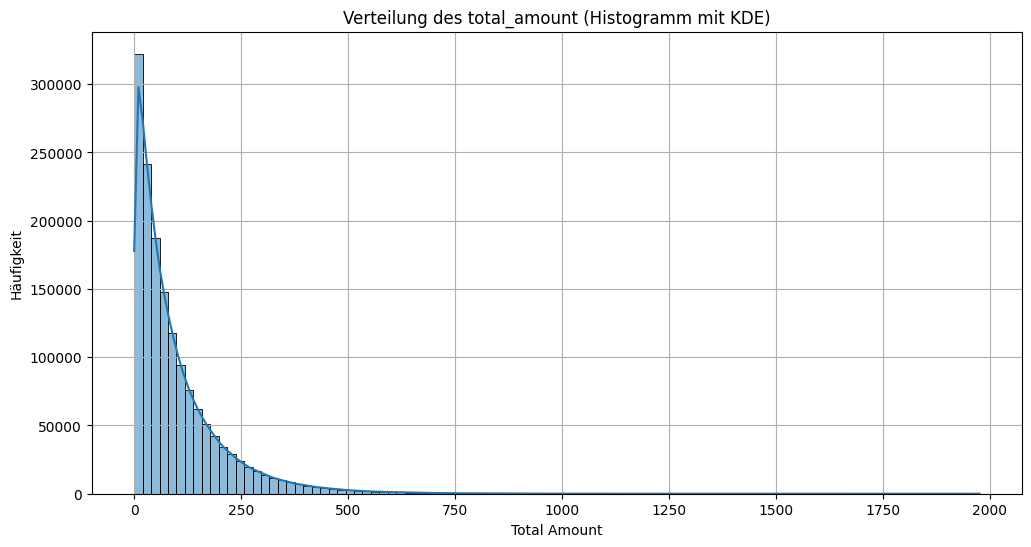

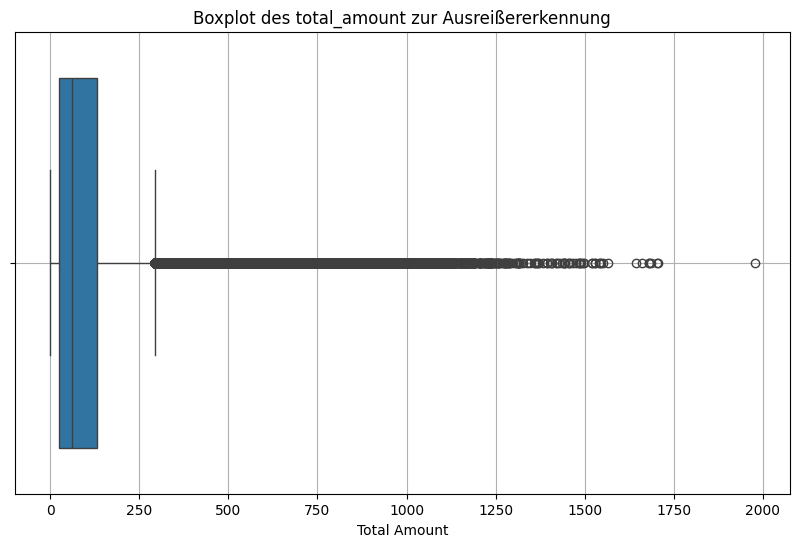

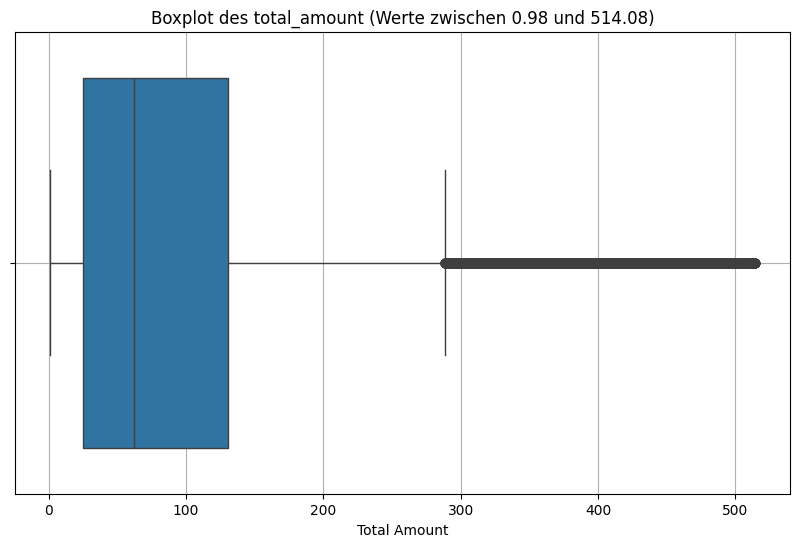

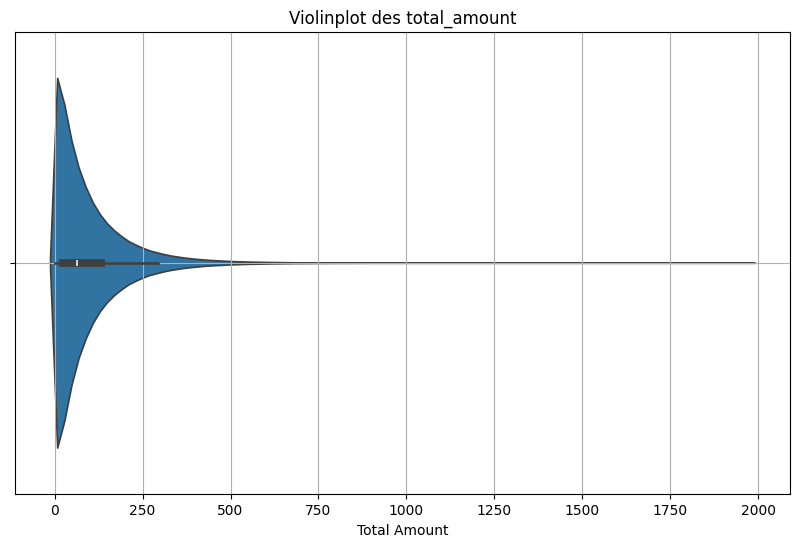

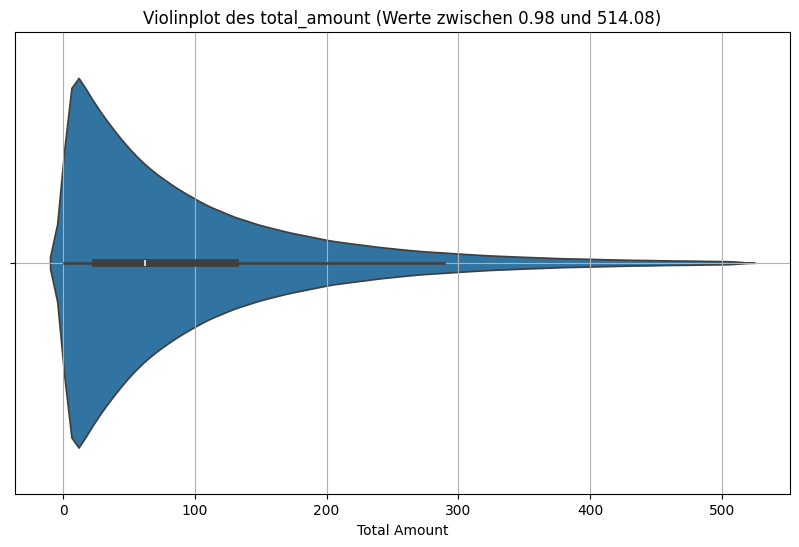

In [35]:
# Histogramm und KDE-Plot
plt.figure(figsize=(12, 6))
sns.histplot(transactions_enriched['total_amount'], kde=True, bins=100) # bins anpassen je nach Daten
plt.title('Verteilung des total_amount (Histogramm mit KDE)')
plt.xlabel('Total Amount')
plt.ylabel('Häufigkeit')
# Log-Skala kann helfen, wenn die Daten stark rechtsschief sind
# plt.yscale('log') # Bei Bedarf einkommentieren
plt.grid(True)
plt.show()

# Boxplot zur Identifizierung von Ausreißern
plt.figure(figsize=(10, 6))
sns.boxplot(x=transactions_enriched['total_amount'])
plt.title('Boxplot des total_amount zur Ausreißererkennung')
plt.xlabel('Total Amount')
plt.grid(True)
plt.show()

# Ein Boxplot ohne die extremsten Ausreißer, um die "Hauptverteilung" besser zu sehen
# Zum Beispiel: Werte zwischen dem 1. und 99. Perzentil anzeigen
q01 = transactions_enriched['total_amount'].quantile(0.01)
q99_boxplot = transactions_enriched['total_amount'].quantile(0.99)
filtered_amounts_for_boxplot = transactions_enriched[
    (transactions_enriched['total_amount'] >= q01) &
    (transactions_enriched['total_amount'] <= q99_boxplot)
]['total_amount']

if not filtered_amounts_for_boxplot.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=filtered_amounts_for_boxplot)
    plt.title(f'Boxplot des total_amount (Werte zwischen {q01:.2f} und {q99_boxplot:.2f})')
    plt.xlabel('Total Amount')
    plt.grid(True)
    plt.show()
else:
    print("\nKonnte keinen gefilterten Boxplot erstellen, möglicherweise sind alle Daten Ausreißer oder der Bereich ist zu eng.")


# Violinplot (kombiniert Boxplot mit KDE)
plt.figure(figsize=(10, 6))
sns.violinplot(x=transactions_enriched['total_amount'])
plt.title('Violinplot des total_amount')
plt.xlabel('Total Amount')
plt.grid(True)
plt.show()

if not filtered_amounts_for_boxplot.empty:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=filtered_amounts_for_boxplot)
    plt.title(f'Violinplot des total_amount (Werte zwischen {q01:.2f} und {q99_boxplot:.2f})')
    plt.xlabel('Total Amount')
    plt.grid(True)
    plt.show()

99 prozent aller total_amount werte liegen zwischen 514 und 0. Die ausreißer gehen bis 2000. Wir haben es also mit rechts schiefen daten zu tun.

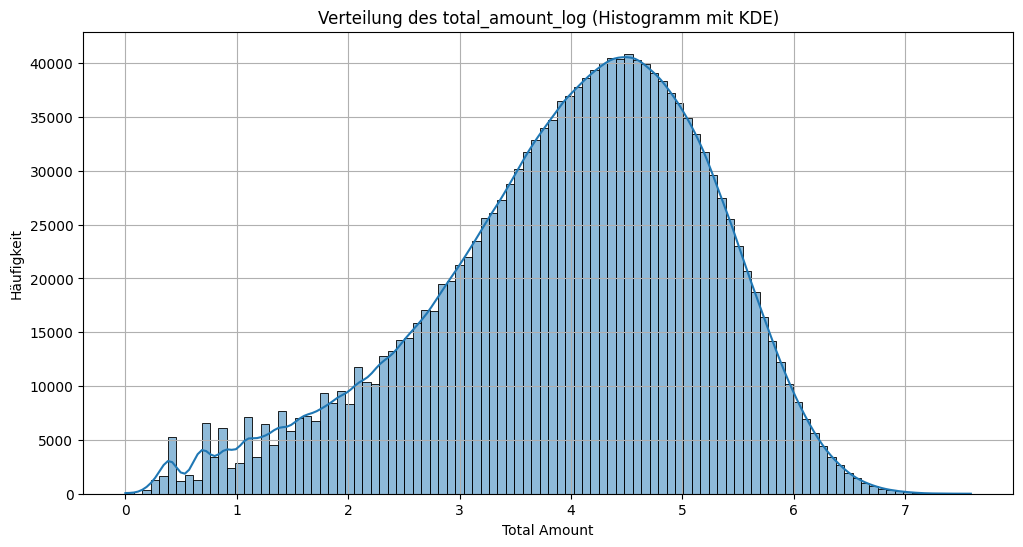

In [36]:
# Histogramm und KDE-Plot
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(transactions_enriched['total_amount']), kde=True, bins=100) # bins anpassen je nach Daten
plt.title('Verteilung des total_amount_log (Histogramm mit KDE)')
plt.xlabel('Total Amount')
plt.ylabel('Häufigkeit')
# Log-Skala kann helfen, wenn die Daten stark rechtsschief sind
# plt.yscale('log') # Bei Bedarf einkommentieren
plt.grid(True)
plt.show()

Wir sehen der logarithmus gibt uns eine wunderbare form für den total_amount. Das sollten wir also benutzen.

In [37]:
# Um Null zentrieren (Mean Centering)
# Berechne den Mittelwert der log-transformierten Spalte
mean_log_amount = transactions_enriched['total_amount_log'].mean()
transactions_enriched['total_amount_log_centered'] = transactions_enriched['total_amount_log'] - mean_log_amount

KeyError: 'total_amount_log'

c:\Users\DavidLeatham\miniconda3\envs\python11\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


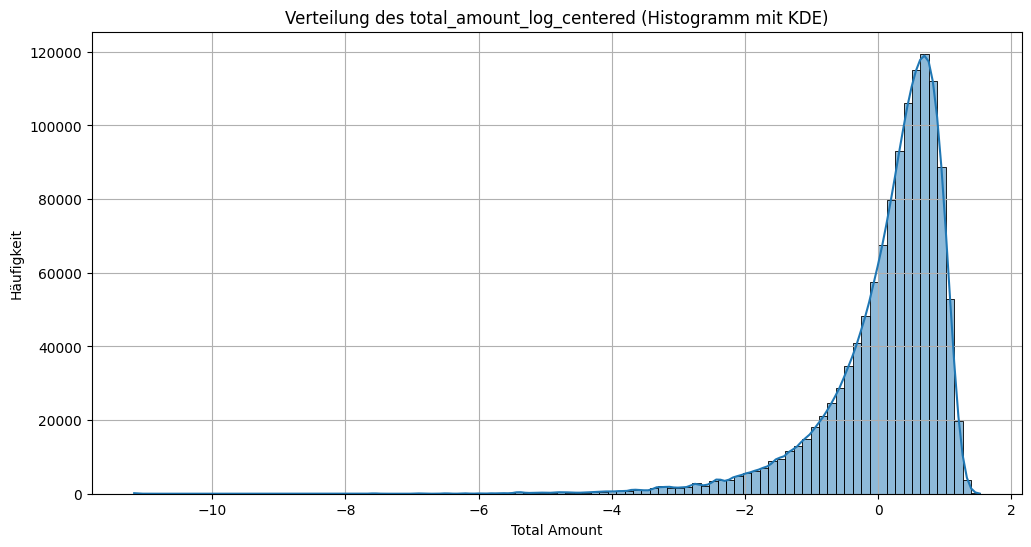

In [ ]:
# Histogramm und KDE-Plot
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(transactions_enriched['total_amount_log_centered']), kde=True, bins=100) # bins anpassen je nach Daten
plt.title('Verteilung des total_amount_log_centered (Histogramm mit KDE)')
plt.xlabel('Total Amount')
plt.ylabel('Häufigkeit')
# Log-Skala kann helfen, wenn die Daten stark rechtsschief sind
# plt.yscale('log') # Bei Bedarf einkommentieren
plt.grid(True)
plt.show()

Das das sieht fürs erste gut aus.

# Pipeline

## Tabelle erstellen

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
transactions_for_pipeline = transactions_enriched.copy()
transactions_for_pipeline = transactions_for_pipeline[transactions_for_pipeline['label'] != 'UNKNOWN']

## Helpers

In [ ]:
# Benutzerdefinierter Transformer zur Generierung von Zeit-Features
class TimeFeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Keine Parameter für diesen einfachen Transformer
        pass

    def fit(self, X, y=None):
        # Dieser Transformer lernt nichts aus den Daten,
        # daher gibt es im fit nichts zu tun.
        return self

    def transform(self, X, y=None):
        # X wird ein DataFrame mit den Spalten sein, die diesem Transformer
        # im ColumnTransformer zugewiesen werden (hier: 'transaction_start', 'transaction_end')
        
        # Kopie erstellen, um den ursprünglichen DataFrame nicht zu verändern
        df_transformed = pd.DataFrame(index=X.index)

        # Konvertiere Spalten zu datetime, falls sie nicht bereits sind (Sicherheitsmaßnahme)
        transaction_start = pd.to_datetime(X['transaction_start'])
        transaction_end = pd.to_datetime(X['transaction_end'])

        # 1. Monat (extrahiert aus transaction_start)
        df_transformed['ft_month'] = transaction_start.dt.month

        # 2. Tag (des Monats, extrahiert aus transaction_start)
        df_transformed['ft_day'] = transaction_start.dt.day

        # 3. Abstand zwischen transaction_start und transaction_end (Transaktionsdauer in Sekunden)
        duration = transaction_end - transaction_start
        df_transformed['ft_duration_seconds'] = duration.dt.total_seconds()
        
        # Speichere die Namen der generierten Features für get_feature_names_out
        self.feature_names_out_ = ['ft_month', 'ft_day', 'ft_duration_seconds']
        
        return df_transformed[self.feature_names_out_] # Gibt nur die neuen Spalten zurück

    def get_feature_names_out(self, input_features=None):
        # Gibt die Namen der erzeugten Features zurück
        # Dies ist wichtig für die automatische Benennung von Spalten in der Pipeline
        return self.feature_names_out_

## Pipeline

In [ ]:
# 1. Zielvariable (y) vorbereiten
# Sicherstellen, dass 'label' eine kategorische Spalte ist, falls sie als String geladen wurde
if not pd.api.types.is_categorical_dtype(transactions_for_pipeline['label']):
    transactions_for_pipeline['label'] = transactions_for_pipeline['label'].astype('category')

# Mapping für die Zielvariable: 'FRAUD' -> 1, 'NORMAL' -> 0
# Überprüfe zuerst die Kategorien, um sicherzustellen, dass das Mapping korrekt ist
print(f"Kategorien in 'label': {transactions_for_pipeline['label'].cat.categories}")
try:
    y = transactions_for_pipeline['label'].map({'FRAUD': 1, 'NORMAL': 0})
    # Überprüfen, ob alle Werte gemappt wurden (keine NaNs durch fehlende Keys im Map)
    if y.isnull().any():
        raise ValueError("Nicht alle Werte in 'label' konnten gemappt werden. Überprüfe die Kategorien und das Mapping.")
except Exception as e:
    print(f"Fehler beim Mappen der 'label'-Spalte: {e}")
    print("Stelle sicher, dass die Spalte 'label' nur 'FRAUD' und 'NORMAL' enthält oder passe das Mapping an.")
    # Hier könntest du alternativ abbrechen oder einen Standardwert setzen, je nach Anforderung
    # Für dieses Beispiel gehen wir davon aus, dass das Mapping erfolgreich ist oder korrigiert wird.
    # y = pd.Series([0] * len(transactions_for_pipeline)) # Fallback, nicht empfohlen für Produktion

# 2. Features (X) vorbereiten
X = transactions_for_pipeline.drop('label', axis=1)

Kategorien in 'label': Index(['FRAUD', 'NORMAL'], dtype='object')


C:\Users\DavidLeatham\AppData\Local\Temp\ipykernel_6548\3667656125.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(transactions_for_pipeline['label']):


In [ ]:
# import numpy as np
# from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# Stellen Sie sicher, dass Ihr TimeFeatureGenerator korrekt definiert ist, z.B.:
# from your_module import TimeFeatureGenerator
# oder wenn er im selben Skript definiert ist:
# class TimeFeatureGenerator(BaseEstimator, TransformerMixin):
#     # ... Ihre Implementierung ...
#     pass


# 3. Spaltenlisten für den ColumnTransformer definieren

# Numerische Features für Log-Transformation und Mittelwert-Zentrierung
numerical_features_log_center = ['total_amount'] # Hier die Spalte(n) eintragen

# Kategorische Features für OneHotEncoding
categorical_features_onehot = ['cash_desk']

# Eingabespalten für unseren benutzerdefinierten TimeFeatureGenerator
datetime_features_input_for_time_generator = ['transaction_start', 'transaction_end']


# 4. Transformatoren und Pipelines erstellen

# Pipeline für numerische Features: Log-Transformation und Mittelwert-Zentrierung
numerical_log_center_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one')), # KORRIGIERT
    ('mean_centering', StandardScaler(with_std=False))
])

# Für OneHotEncoding
onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Pipeline für die Erstellung und Skalierung der Zeit-Features
# Annahme: TimeFeatureGenerator ist bereits definiert
time_feature_processing_pipeline = Pipeline(steps=[
    ('time_generator', TimeFeatureGenerator()), # Nimmt ['transaction_start', 'transaction_end'] als Input
    ('scaler', StandardScaler())               # Skaliert die Ausgabe von time_generator
])


# 5. ColumnTransformer erstellen
preprocessor = ColumnTransformer(
    transformers=[
        # Tupel: (Name des Schritts, Transformer-Objekt, Spaltenliste für diesen Transformer)
        ('num_log_center', numerical_log_center_transformer, numerical_features_log_center),
        ('onehot_cash_desk', onehot_transformer, categorical_features_onehot),
        ('time_features_creation_and_scaling', time_feature_processing_pipeline, datetime_features_input_for_time_generator)
    ],
    remainder='drop'  # Wichtig: Alle nicht explizit in einem Transformer genannten Spalten
                      # aus dem ursprünglichen DataFrame werden verworfen.
                      # Wenn du andere Spalten aus 'transactions_cleaned' behalten möchtest
                      # (z.B. 'n_lines' etc. ohne Transformation),
                      # setze remainder='passthrough'.
)

In [ ]:
try:
    transactions_processed_array = preprocessor.fit_transform(transactions_for_pipeline)

    # Schritt B: Die Namen der Ausgabespalten abrufen
    # Dies funktioniert, weil unsere Transformatoren (OneHotEncoder mit sparse_output=False
    # und unser TimeFeatureGenerator mit get_feature_names_out) dies unterstützen.
    feature_names_out = preprocessor.get_feature_names_out()
    
    print("\n--- Namen der Ausgabespalten des Preprocessors ---")
    print(list(feature_names_out)) # Ausgabe als Liste für bessere Lesbarkeit

    # Schritt C: Das transformierte NumPy-Array in einen Pandas DataFrame umwandeln
    # Dies gibt dir die tabellarische "Datengestalt" mit den korrekten Spaltennamen.
    transactions_processed_df = pd.DataFrame(
        transactions_processed_array,
        columns=feature_names_out,
        index=transactions_for_pipeline.index # Behalte den ursprünglichen Index bei
    )

    print("\n--- Transformierter DataFrame (Datengestalt nach Preprocessing) ---")
    print(transactions_processed_df.head())

    print("\n--- Info zum transformierten DataFrame ---")
    transactions_processed_df.info()

    print("\n--- Form des transformierten DataFrames (Zeilen, Spalten) ---")
    print(transactions_processed_df.shape)

except Exception as e:
    print(f"\nEin Fehler ist bei der Anwendung des Preprocessors oder der Anzeige der Datengestalt aufgetreten:")
    print(e)
    print("\nStelle sicher, dass der DataFrame 'transactions_for_pipeline' existiert und die Spalten")
    print("'cash_desk', 'transaction_start', und 'transaction_end' enthält.")


--- Namen der Ausgabespalten des Preprocessors ---
['num_log_center__total_amount', 'onehot_cash_desk__cash_desk_0', 'onehot_cash_desk__cash_desk_1', 'onehot_cash_desk__cash_desk_2', 'onehot_cash_desk__cash_desk_3', 'time_features_creation_and_scaling__ft_month', 'time_features_creation_and_scaling__ft_day', 'time_features_creation_and_scaling__ft_duration_seconds']

--- Transformierter DataFrame (Datengestalt nach Preprocessing) ---
    num_log_center__total_amount  onehot_cash_desk__cash_desk_0  \
2                       1.907088                            0.0   
5                       0.345883                            0.0   
9                       1.398945                            0.0   
17                      1.791218                            0.0   
32                      0.099722                            0.0   

    onehot_cash_desk__cash_desk_1  onehot_cash_desk__cash_desk_2  \
2                             0.0                            1.0   
5                     

In [ ]:
# # 3. Spaltenlisten für den ColumnTransformer definieren
# # Zuerst nur 'cash_desk' für OneHotEncoding
# # Wichtig: Auch wenn 'cash_desk' int64 ist, kann OneHotEncoder es als kategorisch behandeln.
# # Wenn es sehr viele unique int-Werte gäbe, die keine Kategorien darstellen, wäre es ein anderes Thema.
# categorical_features_onehot = ['cash_desk']

# # --- HIER WÜRDEN SPÄTER LISTEN FÜR ANDERE TRANSFORMATIONEN HINKOMMEN ---
# # Beispiel für numerische Spalten, die skaliert werden könnten:
# # numerical_features_scaling = ['total_amount', 'n_lines', 'customer_feedback', 'damage']

# # Beispiel für andere kategorische Spalten:
# # categorical_features_other_encoding = ['store_id', 'payment_medium', 'location', 'state', 'urbanization']

# # Beispiel für Datumsspalten (würden spezielle Feature-Engineering-Schritte benötigen,
# # die oft in einer eigenen Funktion oder einem benutzerdefinierten Transformer gekapselt werden):
# # datetime_features = ['transaction_start', 'transaction_end', 'opening_date', 'sco_introduction']

# # Beispiel für Spalten, die einfach durchgereicht (passthrough) oder explizit gedroppt (drop) werden sollen,
# # wenn remainder nicht 'drop' wäre oder man spezifische Spalten anders behandeln will als mit remainder.
# # pass_through_features = ['id'] # Wenn 'id' für irgendetwas später gebraucht würde
# # drop_features = ['id'] # Wenn remainder='passthrough' und 'id' soll trotzdem weg


# # 4. Transformatoren erstellen
# onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# # --- HIER WÜRDEN SPÄTER ANDERE TRANSFORMATOREN INITIALISIERT ---
# # scaler = StandardScaler()
# # imputer_mean = SimpleImputer(strategy='mean')
# # imputer_median = SimpleImputer(strategy='median')


# # 5. ColumnTransformer erstellen
# # Zuerst nur mit 'cash_desk'. Alle anderen Spalten werden wegen remainder='drop' entfernt.
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot_cash_desk', onehot_transformer, categorical_features_onehot)
#         # --- HIER KÖNNEN WEITERE TRANSFORMER-TUPEL HINZUGEFÜGT WERDEN ---
#         # Beispiel:
#         # ('num_scale', scaler, numerical_features_scaling),
#         # ('cat_other_onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_other_encoding),
#         # Wenn du eine Pipeline für eine einzelne Spalte oder Spaltengruppe brauchst (z.B. Imputieren DANN Skalieren):
#         # ('num_impute_then_scale_feedback', Pipeline(steps=[
#         #                                     ('imputer', SimpleImputer(strategy='median')),
#         #                                     ('scaler', StandardScaler())
#         #                                ]), ['customer_feedback']), # Beachte die Liste um den Spaltennamen
#     ],
#     remainder='drop'  # Wichtig: Alle nicht explizit genannten Spalten werden verworfen
# )

In [ ]:
# 6. Vollständige Pipeline erstellen
# Hier wird LogisticRegression als Platzhalter-Modell verwendet.
# Du kannst jedes andere Scikit-learn-kompatible Modell einsetzen.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear')) # solver='liblinear' ist oft gut für kleinere Datensätze oder wenn Features stark variieren
])

# 7. Daten aufteilen (optional für die reine Pipeline-Definition, aber notwendig für Training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() > 1 and y.notnull().all() else None)

# 8. Pipeline trainieren (optional für reine Definition, aber zeigt den Workflow)
print("\nStarte Training der Pipeline (nur mit 'cash_desk' als Feature)...")
if y_train.isnull().any():
    print("WARNUNG: y_train enthält NaN-Werte. Dies kann zu Fehlern beim Training führen.")
    print("Anzahl der NaN-Werte in y_train:", y_train.isnull().sum())
else:
    model_pipeline.fit(X_train, y_train)
    print("Training abgeschlossen.")

    # Vorhersagen und Bewertung (optional)
    accuracy = model_pipeline.score(X_test, y_test)
    print(f"Genauigkeit des Modells auf den Testdaten: {accuracy:.4f}")

    # Um die transformierten Features zu sehen (nach dem Preprocessing)
    # X_train_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train)
    # print(f"\nShape der transformierten Trainingsdaten: {X_train_transformed.shape}")
    # print("Spaltennamen nach OneHotEncoding von 'cash_desk' (Beispielhaft):")
    # print(model_pipeline.named_steps['preprocessor'].get_feature_names_out())


Starte Training der Pipeline (nur mit 'cash_desk' als Feature)...
Training abgeschlossen.
Genauigkeit des Modells auf den Testdaten: 0.9679


# Aufgaben

Bereinigung

 - null values
 - spalten löschen
 - daten typen convertieren
 - daten groupen
 - ausreißer prüfen
 - dupletten prüfen

transactions_enriched

In [38]:
transactions_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558245 entries, 0 to 1558244
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype          
---  ------                        --------------    -----          
 0   id                            1558245 non-null  object         
 1   store_id                      1558245 non-null  object         
 2   cash_desk                     1558245 non-null  int64          
 3   transaction_start             1558245 non-null  datetime64[us] 
 4   transaction_end               1558245 non-null  datetime64[us] 
 5   total_amount                  1558245 non-null  float64        
 6   n_lines                       1558245 non-null  int64          
 7   payment_medium                1558245 non-null  object         
 8   customer_feedback             108330 non-null   float64        
 9   damage                        155692 non-null   float64        
 10  label                         1558245 non-null  object

transactions_cleaned

In [39]:
transactions_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155692 entries, 2 to 1558199
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   155692 non-null  object 
 1   store_id             155692 non-null  object 
 2   total_amount         155692 non-null  float64
 3   n_lines              155692 non-null  int64  
 4   payment_medium       155692 non-null  object 
 5   customer_feedback    10641 non-null   float64
 6   damage               155692 non-null  float64
 7   label                155692 non-null  object 
 8   opening_date         155692 non-null  object 
 9   location             155692 non-null  object 
 10  state                155692 non-null  object 
 11  urbanization         155692 non-null  object 
 12  sco_introduction     155692 non-null  object 
 13  cash_desk_0          155692 non-null  int32  
 14  cash_desk_1          155692 non-null  int32  
 15  cash_desk_2          

In [41]:
# Aussehen
transactions_cleaned

,id,store_id,total_amount,n_lines,payment_medium,customer_feedback,damage,label,opening_date,location,state,urbanization,sco_introduction,cash_desk_0,cash_desk_1,cash_desk_2,cash_desk_3,ft_month,ft_day,ft_duration_seconds
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,0,1,0,2,2,257.434607
5,fc8400da-2ac2-4984-bb8f-a6ea29df955a,b0973ffa-ce15-41e0-9de7-1390598e24f2,75.58,3,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0,2,2,36.404849
9,3d7dbe6e-2a67-4a4d-8011-394b44774c53,b0973ffa-ce15-41e0-9de7-1390598e24f2,218.51,23,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0,2,2,191.530141
17,d54e5513-bdbe-4129-bafc-dc4a15747260,b0973ffa-ce15-41e0-9de7-1390598e24f2,323.95,27,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,1,0,0,2,2,167.177041
32,6e1a71c4-b210-427e-8882-5385f9b9253e,b0973ffa-ce15-41e0-9de7-1390598e24f2,58.87,4,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02,0,0,0,1,2,2,21.311571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558167,93e0f4b3-810a-46c7-837e-7b84b2a4c673,ed996b17-17d6-47e8-9262-d1d02b52cdb4,47.28,8,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,1,0,0,0,12,30,62.665744
1558170,81d32eb7-7b5d-48e5-9c25-18a0148ba907,ed996b17-17d6-47e8-9262-d1d02b52cdb4,264.25,22,CREDIT_CARD,10.0,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,0,1,0,12,30,199.092689
1558173,14ce6f9e-64a9-4c93-b834-cde34d80704d,ed996b17-17d6-47e8-9262-d1d02b52cdb4,297.95,38,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,1,0,0,12,30,286.465321
1558175,c63b715f-4b23-485a-92e9-7bca82775d4c,ed996b17-17d6-47e8-9262-d1d02b52cdb4,398.57,27,CREDIT_CARD,NaN,0.0,NORMAL,1994-09-19,München,Bayern,TOWNS,2022-02-06,0,0,1,0,12,30,171.428927


In [42]:
#Wertebereiche
# Anzeigen der eindeutigen Werte für 'ft_month' und 'ft_day'
print("Wertebereich von 'ft_month':", transactions_cleaned['ft_month'].unique())
print("Wertebereich von 'ft_day':", transactions_cleaned['ft_day'].unique())

# Alternativ: Wertebereich mit min und max
print("Min und Max von 'ft_month':", transactions_cleaned['ft_month'].min(), "-", transactions_cleaned['ft_month'].max())
print("Min und Max von 'ft_day':", transactions_cleaned['ft_day'].min(), "-", transactions_cleaned['ft_day'].max())


Wertebereich von 'ft_month': [ 2  3  4  5  6  7  8  9 10 11 12  1]
Wertebereich von 'ft_day': [ 2  3  4  5  7  8  9 10 11 12 14 15 16 17 18 19 21 22 23 24 25 26 28  1
 29 30 31  6 13 20 27]
Min und Max von 'ft_month': 1 - 12
Min und Max von 'ft_day': 1 - 31


In [43]:
# fehlende Werte
# Überblick über fehlende Werte je Spalte
missing_values = transactions_cleaned.isnull().sum()

# Nur Spalten mit mindestens einem fehlenden Wert anzeigen
missing_values = missing_values[missing_values > 0]

print("Spalten mit fehlenden Werten:\n", missing_values)


Spalten mit fehlenden Werten:
 customer_feedback    145051
dtype: int64
